## **ACKNOWLEDGEMENT**

This code is inspired by https://github.com/siat-nlp/MAMS-for-ABSA.

## **SETUP**

### **Imports**

In [175]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
!pip install adabound
!pip install pytorch_pretrained_bert

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import os
import numpy as np
import pickle
import yaml
import random
import spacy
import re
import json
import operator
import time
import adabound

In [10]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

In [178]:
from xml.etree.ElementTree import parse
from pytorch_pretrained_bert import BertModel, BertTokenizer

In [179]:
import torch
import torch.nn.functional as F
from torch import nn
from torch import optim
from torch.nn import init
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

### **Constants**

In [180]:
PAD = '<pad>'
UNK = '<unk>'
ASPECT = '<aspect>'

PAD_INDEX = 0
UNK_INDEX = 1
ASPECT_INDEX = 2

INF = 1e9

In [181]:
url = re.compile('(<url>.*</url>)')
spacy_en = spacy.load('en_core_web_sm')
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# **CLASSES**

### **Data**

In [182]:
class ABSADataset(Dataset):

    def __init__(self, path, input_list):
        super(ABSADataset, self).__init__()
        data = np.load(path)
        self.data = {}
        for key, value in data.items():
            self.data[key] = torch.tensor(value).long()
        self.len = self.data['label'].size(0)
        self.input_list = input_list

    def __getitem__(self, index):
        return_value = []
        for input in self.input_list:
            return_value.append(self.data[input][index])
        return_value.append(self.data['label'][index])
        return return_value

    def __len__(self):
        return self.len

In [183]:
class Vocab(object):

    def __init__(self):
        self._count_dict = dict()
        self._predefined_list = [PAD, UNK, ASPECT]

    def add(self, word):
        if word in self._count_dict:
            self._count_dict[word] += 1
        else:
            self._count_dict[word] = 1

    def add_list(self, words):
        for word in words:
            self.add(word)

    def get_vocab(self, max_size=None, min_freq=0):
        # 
        sorted_words = sorted(self._count_dict.items(), key=operator.itemgetter(1), reverse=True)
        word2index = {}
        for word in self._predefined_list:
            word2index[word] = len(word2index)
        for word, freq in sorted_words:
            if word in word2index:
                continue
            if (max_size is not None and len(word2index) >= max_size) or freq < min_freq:
                word2index[word] = word2index[UNK]
            else:
                word2index[word] = len(word2index)
        index2word = {}
        index2word[word2index[UNK]] = UNK
        for word, index in word2index.items():
            if index == word2index[UNK]:
                continue
            else:
                index2word[index] = word
        return word2index, index2word

### **Model**

In [184]:
class Attention(nn.Module):
    """
    The base class of attention.
    """

    def __init__(self, dropout):
        super(Attention, self).__init__()
        self.dropout = dropout

    def forward(self, query, key, value, mask=None):
        """
        query: FloatTensor (batch_size, query_size) or FloatTensor (batch_size, num_queries, query_size)
        key: FloatTensor (batch_size, time_step, key_size)
        value: FloatTensor (batch_size, time_step, hidden_size)
        mask: ByteTensor (batch_size, time_step) or ByteTensor (batch_size, num_queries, time_step)
        """
        single_query = False
        if len(query.size()) == 2:
            query = query.unsqueeze(1)
            single_query = True
        if mask is not None:
            if len(mask.size()) == 2:
                mask = mask.unsqueeze(1)
            else:
                assert mask.size(1) == query.size(1)
        score = self._score(query, key) # FloatTensor (batch_size, num_queries, time_step)
        weights = self._weights_normalize(score, mask)
        weights = F.dropout(weights, p=self.dropout, training=self.training)
        output = weights.matmul(value)
        if single_query:
            output = output.squeeze(1)
        return output

    def _score(self, query, key):
        raise NotImplementedError('Attention score method is not implemented.')

    def _weights_normalize(self, score, mask):
        if not mask is None:
            score = score.masked_fill(mask == 0, -INF)
        weights = F.softmax(score, dim=-1)
        return weights

    def get_attention_weights(self, query, key, mask=None):
        single_query = False
        if len(query.size()) == 2:
            query = query.unsqueeze(1)
            single_query = True
        if mask is not None:
            if len(mask.size()) == 2:
                mask = mask.unsqueeze(1)
            else:
                assert mask.size(1) == query.size(1)
        score = self._score(query, key)  # FloatTensor (batch_size, num_queries, time_step)
        weights = self._weights_normalize(score, mask)
        weights = F.dropout(weights, p=self.dropout, training=self.training)
        if single_query:
            weights = weights.squeeze(1)
        return weights

In [185]:
class BilinearAttention(Attention):

    def __init__(self, query_size, key_size, dropout=0):
        super(BilinearAttention, self).__init__(dropout)
        self.weights = nn.Parameter(torch.FloatTensor(query_size, key_size))
        init.xavier_uniform_(self.weights)

    def _score(self, query, key):
        """
        query: FloatTensor (batch_size, num_queries, query_size)
        key: FloatTensor (batch_size, time_step, key_size)
        """
        score = query.matmul(self.weights).matmul(key.transpose(1, 2))
        return score

In [186]:
class ConcatAttention(Attention):

    def __init__(self, query_size, key_size, dropout=0):
        super(ConcatAttention, self).__init__(dropout)
        self.query_weights = nn.Parameter(torch.Tensor(query_size, 1))
        self.key_weights = nn.Parameter(torch.Tensor(key_size, 1))
        init.xavier_uniform_(self.query_weights)
        init.xavier_uniform_(self.key_weights)

    def _score(self, query, key):
        """
        query: FloatTensor (batch_size, num_queries, query_size)
        key: FloatTensor (batch_size, time_step, key_size)
        """
        batch_size, num_queries, time_step = query.size(0), query.size(1), key.size(1)
        query = query.matmul(self.query_weights).expand(batch_size, num_queries, time_step)
        key = key.matmul(self.key_weights).transpose(1, 2).expand(batch_size, num_queries, time_step)
        score = query + key
        return score

In [187]:
class BertCapsuleNetwork(nn.Module):

    def __init__(self, bert, bert_size, capsule_size, dropout, num_categories):
        super(BertCapsuleNetwork, self).__init__()
        self.bert = bert
        self.bert_size = bert_size
        self.capsule_size = capsule_size
        self.aspect_transform = nn.Sequential(
            nn.Linear(bert_size, capsule_size),
            nn.Dropout(dropout)
        )
        self.sentence_transform = nn.Sequential(
            nn.Linear(bert_size, capsule_size),
            nn.Dropout(dropout)
        )
        self.norm_attention = ConcatAttention(capsule_size, capsule_size)
        self.guide_capsule = nn.Parameter(
            torch.Tensor(num_categories, capsule_size)
        )
        self.guide_weight = nn.Parameter(
            torch.Tensor(capsule_size, capsule_size)
        )
        self.scale = nn.Parameter(torch.tensor(5.0))
        self.capsule_projection = nn.Linear(bert_size, bert_size * num_categories)
        self.dropout = dropout
        self.num_categories = num_categories
        self._reset_parameters()

    def _reset_parameters(self):
        init.xavier_uniform_(self.guide_capsule)
        init.xavier_uniform_(self.guide_weight)

    def load_sentiment(self, path):
        sentiment = np.load(path)
        e1 = np.mean(sentiment)
        d1 = np.std(sentiment)
        e2 = 0
        d2 = np.sqrt(2.0 / (sentiment.shape[0] + sentiment.shape[1]))
        sentiment = (sentiment - e1) / d1 * d2 + e2
        self.guide_capsule.data.copy_(torch.tensor(sentiment))

    def forward(self, bert_token, bert_segment):
        # BERT encoding
        encoder_layer, _ = self.bert(bert_token, bert_segment, output_all_encoded_layers=False)
        batch_size, segment_len = bert_segment.size()
        max_segment_len = bert_segment.argmax(dim=-1, keepdim=True)
        batch_arrange = torch.arange(segment_len).unsqueeze(0).expand(batch_size, segment_len).to(bert_segment.device)
        segment_mask = batch_arrange <= max_segment_len
        sentence_mask = segment_mask & (1 - bert_segment).byte()
        aspect_mask = bert_segment
        sentence_lens = sentence_mask.long().sum(dim=1, keepdim=True)
        # aspect average pooling
        aspect_lens = aspect_mask.long().sum(dim=1, keepdim=True)
        aspect = encoder_layer.masked_fill(aspect_mask.unsqueeze(-1) == 0, 0)
        aspect = aspect.sum(dim=1, keepdim=False) / aspect_lens.float()
        # sentence encode layer
        max_len = sentence_lens.max().item()
        sentence = encoder_layer[:, 0: max_len].contiguous()
        sentence_mask = sentence_mask[:, 0: max_len].contiguous()
        sentence = sentence.masked_fill(sentence_mask.unsqueeze(-1) == 0, 0)
        # primary capsule layer
        sentence = self.sentence_transform(sentence)
        primary_capsule = squash(sentence, dim=-1)
        aspect = self.aspect_transform(aspect)
        aspect_capsule = squash(aspect, dim=-1)
        # aspect aware normalization
        norm_weight = self.norm_attention.get_attention_weights(aspect_capsule, primary_capsule, sentence_mask)
        # capsule guided routing
        category_capsule = self._capsule_guided_routing(primary_capsule, norm_weight)
        category_capsule_norm = torch.sqrt(torch.sum(category_capsule * category_capsule, dim=-1, keepdim=False))
        return category_capsule_norm

    def _capsule_guided_routing(self, primary_capsule, norm_weight):
        guide_capsule = squash(self.guide_capsule)
        guide_matrix = primary_capsule.matmul(self.guide_weight).matmul(guide_capsule.transpose(0, 1))
        guide_matrix = F.softmax(guide_matrix, dim=-1)
        guide_matrix = guide_matrix * norm_weight.unsqueeze(-1) * self.scale  # (batch_size, time_step, num_categories)
        category_capsule = guide_matrix.transpose(1, 2).matmul(primary_capsule)
        category_capsule = F.dropout(category_capsule, p=self.dropout, training=self.training)
        category_capsule = squash(category_capsule)
        return category_capsule

In [188]:
class CapsuleLoss(nn.Module):

    def __init__(self, smooth=0.1, lamda=0.6):
        super(CapsuleLoss, self).__init__()
        self.smooth = smooth
        self.lamda = lamda

    def forward(self, input, target):
        one_hot = torch.zeros_like(input).to(input.device)
        one_hot = one_hot.scatter(1, target.unsqueeze(-1), 1)
        a = torch.max(torch.zeros_like(input).to(input.device), 1 - self.smooth - input)
        b = torch.max(torch.zeros_like(input).to(input.device), input - self.smooth)
        loss = one_hot * a * a + self.lamda * (1 - one_hot) * b * b
        loss = loss.sum(dim=1, keepdim=False)
        return loss.mean()

# **FUNCTIONS**

In [189]:
def parse_sentence_term(path, lowercase=False):
    # parse each sentence into a tree by built-in xml function
    tree = parse(path)
    
    # from here down parse each sentence to 
    # '[text], [term], [polarity], [from], [to]' with '_split_' inbetween,
    # then append to data list. 
    sentences = tree.getroot()
    data = []
    split_char = '__split__'
    for sentence in sentences:
        text = sentence.find('text')
        if text is None:
            continue
        text = text.text
        if lowercase:
            text = text.lower()
        aspectTerms = sentence.find('aspectTerms')
        if aspectTerms is None:
            continue
        for aspectTerm in aspectTerms:
            term = aspectTerm.get('term')
            if lowercase:
                term = term.lower()
            polarity = aspectTerm.get('polarity')
            start = aspectTerm.get('from')
            end = aspectTerm.get('to')
            piece = text + split_char + term + split_char + polarity + split_char + start + split_char + end
            data.append(piece)
    return data

In [190]:
def category_filter(data, remove_list):
    # remove conflicts, only allows polarity 'positive', 'neutral', 'negative'
    remove_set = set(remove_list)
    filtered_data = []
    for text in data:
        if not text.split('__split__')[2] in remove_set:
            filtered_data.append(text)
    return filtered_data

In [191]:
def check(x):
    return len(x) >= 1 and not x.isspace()

In [192]:
def tokenizer(text):
    tokens = [tok.text for tok in spacy_en.tokenizer(url.sub('@URL@', text))]
    return list(filter(check, tokens))

In [193]:
def build_vocab(data, max_size, min_freq):
    if max_size == 'None':
        max_size = None
    vocab = Vocab()
    for piece in data:
        text = piece.split('__split__')[0]
        text = tokenizer(text)
        vocab.add_list(text)
    return vocab.get_vocab(max_size=max_size, min_freq=min_freq)

In [194]:
def save_term_data(data, word2index, path):
    dirname = os.path.dirname(path)
    if not os.path.exists(dirname):
        os.makedirs(dirname)
    sentence = []
    aspect = []
    label = []
    context = []
    bert_token = []
    bert_segment = []
    td_left = []
    td_right = []
    f = lambda x: word2index[x] if x in word2index else word2index[UNK]
    g = lambda x: list(map(f, tokenizer(x)))
    d = {
        'negative': 0,
        'neutral': 1,
        'positive': 2,
        'conflict': 3
    }
    for piece in data:
        text, term, polarity, start, end = piece.split('__split__')
        start, end = int(start), int(end)
        assert text[start: end] == term
        # sentence appends tokenizer of text
        sentence.append(g(text))
        # aspect appends tokenizer of term
        aspect.append(g(term))
        # label appends index of polarity (based on d)
        label.append(d[polarity])
        # left extracts text to left of term
        left_part = g(text[:start])
        # right extracts text to right of term
        right_part = g(text[end:])
        # masking the term, show only text without term
        context.append(left_part + [ASPECT_INDEX] + right_part)
        bert_sentence = bert_tokenizer.tokenize(text)
        bert_aspect = bert_tokenizer.tokenize(term)
        # appends bert_text, bert_sentence, bert_aspect to token
        bert_token.append(bert_tokenizer.convert_tokens_to_ids(['[CLS]'] + bert_sentence + ['[SEP]'] + bert_aspect + ['[SEP]']))
        bert_segment.append([0] * (len(bert_sentence) + 2) + [1] * (len(bert_aspect) + 1))
        # td left appends the text from 0 to end of term
        td_left.append(g(text[:end]))
        # td right appends the text from start of term to end of sentence
        td_right.append(g(text[start:])[::-1])
        assert len(bert_token[-1]) == len(bert_segment[-1])

    max_length = lambda x: max([len(y) for y in x])
    sentence_max_len = max_length(sentence)
    aspect_max_len = max_length(aspect)
    context_max_len = max_length(context)
    bert_max_len = max_length(bert_token)
    td_left_max_len = max_length(td_left)
    td_right_max_len = max_length(td_right)
    num = len(data)
    for i in range(num):
        # pads each list
        sentence[i].extend([0] * (sentence_max_len - len(sentence[i])))
        aspect[i].extend([0] * (aspect_max_len - len(aspect[i])))
        context[i].extend([0] * (context_max_len - len(context[i])))
        bert_token[i].extend([0] * (bert_max_len - len(bert_token[i])))
        bert_segment[i].extend([0] * (bert_max_len - len(bert_segment[i])))
        td_left[i].extend([0] * (td_left_max_len - len(td_left[i])))
        td_right[i].extend([0] * (td_right_max_len - len(td_right[i])))
    sentence = np.asarray(sentence, dtype=np.int32)
    aspect = np.asarray(aspect, dtype=np.int32)
    label = np.asarray(label, dtype=np.int32)
    context = np.asarray(context, dtype=np.int32)
    bert_token = np.asarray(bert_token, dtype=np.int32)
    bert_segment = np.asarray(bert_segment, dtype=np.int32)
    td_left = np.asarray(td_left, dtype=np.int32)
    td_right = np.asarray(td_right, dtype=np.int32)
    np.savez(path, sentence=sentence, aspect=aspect, label=label, context=context, bert_token=bert_token, bert_segment=bert_segment,
             td_left=td_left, td_right=td_right)

In [195]:
def load_sentiment_matrix(glove_path, sentiment_path):
    # load hardcoded sentiments and add to vector analysis
    sentiment_matrix = np.zeros((3, 300), dtype=np.float32)
    sd = json.load(open(sentiment_path, 'r', encoding='utf-8'))
    sd['positive'] = set(sd['positive'])
    sd['negative'] = set(sd['negative'])
    sd['neutral'] = set(sd['neutral'])
    with open(glove_path, 'r', encoding='utf-8') as f:
        for line in f:
            content = line.split(' ')
            word = content[0]
            vec = np.array(list(map(float, content[1:])))
            if word in sd['positive']:
                sentiment_matrix[0] += vec
            elif word in sd['negative']:
                sentiment_matrix[1] += vec
            elif word in sd['neutral']:
                sentiment_matrix[2] += vec
    # normalization
    sentiment_matrix -= sentiment_matrix.mean()
    sentiment_matrix = sentiment_matrix / sentiment_matrix.std() * np.sqrt(2.0 / (300.0 + 3.0))
    return sentiment_matrix

In [196]:
def analyze_term(data):
    num = len(data)
    sentence_lens = []
    aspect_lens = []
    log = {'total': num}
    for piece in data:
        text, term, polarity, _, _ = piece.split('__split__')
        sentence_lens.append(len(tokenizer(text)))
        aspect_lens.append(len(tokenizer(term)))
        if not polarity in log:
            log[polarity] = 0
        log[polarity] += 1
    log['sentence_max_len'] = max(sentence_lens)
    log['sentence_avg_len'] = sum(sentence_lens) / len(sentence_lens)
    log['aspect_max_len'] = max(aspect_lens)
    log['aspect_avg_len'] = sum(aspect_lens) / len(aspect_lens)
    return log

In [197]:
def sentence_clip(sentence):
    mask = (sentence != PAD_INDEX)
    sentence_lens = mask.long().sum(dim=1, keepdim=False)
    max_len = sentence_lens.max().item()
    return sentence[:, :max_len]

In [198]:
def squash(x, dim=-1):
    squared = torch.sum(x * x, dim=dim, keepdim=True)
    scale = torch.sqrt(squared) / (1.0 + squared)
    return scale * x

In [199]:
def make_model():
    base_path = os.path.join(config['base_path'])
    log_path = os.path.join(base_path, 'log/log.yml')
    log = yaml.safe_load(open(log_path))
    bert = BertModel.from_pretrained('bert-base-uncased')
    model = BertCapsuleNetwork(
        bert=bert,
        bert_size=config2['bert_size'],
        capsule_size=config2['capsule_size'],
        dropout=config2['dropout'],
        num_categories=log['num_categories']
    )
    model.load_sentiment(os.path.join(base_path, 'processed/sentiment_matrix.npy'))
    return model

In [200]:
def make_term_data():
    base_path = config['base_path']
    train_path = os.path.join(base_path, 'processed/train.npz')
    val_path = os.path.join(base_path, 'processed/val.npz')
    train_data = ABSADataset(train_path, ['bert_token', 'bert_segment'])
    val_data = ABSADataset(val_path, ['bert_token', 'bert_segment'])
    train_loader = DataLoader(
        dataset=train_data,
        batch_size=config2['batch_size'],
        shuffle=True,
        pin_memory=True
    )
    val_loader = DataLoader(
        dataset=val_data,
        batch_size=config2['batch_size'],
        shuffle=False,
        pin_memory=True
    )
    return train_loader, val_loader

In [201]:
def make_term_test_data(config):
    base_path = config['base_path']
    test_path = os.path.join(base_path, 'processed/test.npz')
    test_data = ABSADataset(test_path, ['bert_token', 'bert_segment'])
    test_loader = DataLoader(
        dataset=test_data,
        batch_size=config['batch_size'],
        shuffle=False,
        pin_memory=True
    )
    return test_loader

In [202]:
def make_optimizer(model):
    lr = config2['learning_rate']
    weight_decay = config2['weight_decay']
    opt = {
        'sgd': optim.SGD,
        'adadelta': optim.Adadelta,
        'adam': optim.Adam,
        'adamax': optim.Adamax,
        'adagrad': optim.Adagrad,
        'asgd': optim.ASGD,
        'rmsprop': optim.RMSprop,
        'adabound': adabound.AdaBound
    }
    if 'momentum' in config:
        optimizer = opt[config2['optimizer']](model.parameters(), lr=lr, weight_decay=weight_decay, momentum=config2['momentum'])
    else:
        optimizer = opt[config2['optimizer']](model.parameters(), lr=lr, weight_decay=weight_decay)
    return optimizer

In [203]:
def eval(model, data_loader, criterion=None):
    total_samples = 0
    correct_samples = 0
    total_loss = 0
    list_of_labels = []
    list_of_predictions = []
    model.eval()
    with torch.no_grad():
        for data in data_loader:
            input0, input1, label = data
            input0, input1, label = input0.cuda(), input1.cuda(), label.cuda()
            logit = model(input0, input1)
            loss = criterion(logit, label).item() if criterion is not None else 0
            total_samples += input0.size(0)
            pred = logit.argmax(dim=1)
            correct_samples += (label == pred).long().sum().item()
            total_loss += loss * input0.size(0)
            list_of_labels.append(label)
            list_of_predictions.append(pred)
    accuracy = correct_samples / total_samples
    avg_loss = total_loss / total_samples
    if criterion is not None:
        return accuracy, avg_loss
    else:
        return accuracy, list_of_labels, list_of_predictions

In [204]:
def load_glove(path, vocab_size, word2index):
    if not os.path.isfile(path):
        raise IOError('Not a file', path)
    glove = np.random.uniform(-0.01, 0.01, [vocab_size, 300])
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            content = line.split(' ')
            if content[0] in word2index:
                glove[word2index[content[0]]] = np.array(list(map(float, content[1:])))
    glove[PAD_INDEX, :] = 0
    return glove

In [205]:
def preprocess():
    # parse data into list
    train_data = parse_sentence_term(config['raw_train_path'], lowercase=config['lowercase'])
    val_data = parse_sentence_term(config['raw_val_path'], lowercase=config['lowercase'])
    test_data = parse_sentence_term(config['raw_test_path'], lowercase=config['lowercase'])
    # filter conflicts
    remove_list = ['conflict']
    train_data = category_filter(train_data, remove_list)
    val_data = category_filter(val_data, remove_list)
    test_data = category_filter(test_data, remove_list)
    # get the word2index and index2word of the parsed data
    word2index, index2word = build_vocab(train_data, max_size=config['max_vocab_size'], min_freq=config['min_vocab_freq'])

    # create path for the processed data
    if not os.path.exists(os.path.join(config["base_path"], 'processed')):
        os.makedirs(os.path.join(config["base_path"], 'processed'))
    
          
    save_term_data(train_data, word2index, os.path.join(config["base_path"], 'processed/train.npz'))
    save_term_data(val_data, word2index, os.path.join(config["base_path"], 'processed/val.npz'))
    save_term_data(test_data, word2index, os.path.join(config["base_path"], 'processed/test.npz'))

    glove = load_glove(config['glove_path'], len(index2word), word2index)

    sentiment_matrix = load_sentiment_matrix(config['glove_path'], config['sentiment_path'])
    np.save(os.path.join(config["base_path"], 'processed/glove.npy'), glove)
    np.save(os.path.join(config["base_path"], 'processed/sentiment_matrix.npy'), sentiment_matrix)
    with open(os.path.join(config["base_path"], 'processed/word2index.pickle'), 'wb') as handle:
        pickle.dump(word2index, handle)
    with open(os.path.join(config["base_path"], 'processed/index2word.pickle'), 'wb') as handle:
        pickle.dump(index2word, handle)
    analyze = analyze_term
    log = {
        'vocab_size': len(index2word),
        'oov_size': len(word2index) - len(index2word),
        'train_data': analyze(train_data),
        'val_data': analyze(val_data),
        'test_data': analyze(test_data),
        'num_categories': 3
    }

    if not os.path.exists(os.path.join(config["base_path"], 'log')):
        os.makedirs(os.path.join(config["base_path"], 'log'))
    with open(os.path.join(config["base_path"], 'log/log.yml'), 'w') as handle:
        yaml.safe_dump(log, handle, encoding='utf-8', allow_unicode=True, default_flow_style=False)

In [206]:
def train():
    train_loader, val_loader = make_term_data()
    global model
    model = model.cuda()
    base_path = config['base_path']
    model_path = os.path.join(base_path, 'checkpoints/%s.pth' % "bert_capsnet")
    if not os.path.exists(os.path.dirname(model_path)):
        os.makedirs(os.path.dirname(model_path))
    with open(os.path.join(base_path, 'processed/index2word.pickle'), 'rb') as handle:
        index2word = pickle.load(handle)
    criterion = CapsuleLoss()
    optimizer = make_optimizer(model)
    max_val_accuracy = 0
    min_val_loss = 100
    global_step = 0
    
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []


    for epoch in range(config2['num_epoches']):
        total_loss = 0
        total_samples = 0
        correct_samples = 0
        start = time.time()
        for i, data in enumerate(train_loader):
            global_step += 1
            model.train()
            input0, input1, label = data
            input0, input1, label = input0.cuda(), input1.cuda(), label.cuda()
            optimizer.zero_grad()
            logit = model(input0, input1)
            loss = criterion(logit, label)
            batch_size = input0.size(0)
            total_loss += batch_size * loss.item()
            total_samples += batch_size
            pred = logit.argmax(dim=1)
            correct_samples += (label == pred).long().sum().item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            optimizer.step()
            if i % 10 == 0 and i > 0:
                train_loss = total_loss / total_samples
                train_accuracy = correct_samples / total_samples
                total_loss = 0
                total_samples = 0
                correct_samples = 0
                val_accuracy, val_loss = eval(model, val_loader, criterion)
                
                print('[epoch %2d] [step %3d] train_loss: %.4f train_acc: %.4f val_loss: %.4f val_acc: %.4f'
                      % (epoch, i, train_loss, train_accuracy, val_loss, val_accuracy))
                if val_accuracy > max_val_accuracy:
                    max_val_accuracy = val_accuracy
                    # torch.save(aspect_term_model.state_dict(), model_path)
                if val_loss < min_val_loss:
                    min_val_loss = val_loss
                    if epoch > 0:
                        torch.save(model.state_dict(), model_path)
        train_losses.append(train_loss)
        train_accs.append(train_accuracy)
        val_losses.append(val_loss)
        val_accs.append(val_accuracy)
        end = time.time()
        print('time: %.4fs' % (end - start))
    print('max_val_accuracy:', max_val_accuracy)
    return train_losses, train_accs, val_losses, val_accs

In [207]:
def make_bert_capsule_network(config):
    base_path = os.path.join(config['base_path'])
    log_path = os.path.join(base_path, 'log/log.yml')
    log = yaml.safe_load(open(log_path))
    config = config['aspect_term_model'][config['aspect_term_model']['type']]
    bert = BertModel.from_pretrained('bert-base-uncased')
    model = BertCapsuleNetwork(
        bert=bert,
        bert_size=config['bert_size'],
        capsule_size=config['capsule_size'],
        dropout=config['dropout'],
        num_categories=log['num_categories']
    )
    model.load_sentiment(os.path.join(base_path, 'processed/sentiment_matrix.npy'))
    return model

In [209]:
def convert_tensor_to_list(tensors):
    ls = []
    for row in tensors:
        for ele in row:
            ls.append(ele.item())

    return ls

In [210]:
def test():
    model = make_model()
    model = model.cuda()
    model_path = os.path.join(config['base_path'], 'checkpoints/%s.pth' % config['mode'])
    model.load_state_dict(torch.load(model_path))
    epochs = config['num_epoches']
    
    test_loader = make_term_test_data(config)
    test_accuracy, test_labels, final_prediction = eval(model, test_loader)
    print('test:\taccuracy: %.4f' % (test_accuracy))
    return test_accuracy, test_labels, final_prediction

# **MAIN**

### **Configuration**

In [211]:
config = {
    "base_path": "drive/MyDrive/CS4248/MAMS-ATSA",
    "mode": "bert_capsnet",
    "glove_path": "drive/MyDrive/CS4248/glove.42B.300d.txt",
    "sentiment_path": "drive/MyDrive/CS4248/sentiment_dict.json",
    "max_vocab_size": None,
    "min_vocab_freq": 0,
    "lowercase": True,
    'bert_size': 768,
    'capsule_size': 300,
    'dropout': 0.1,
    'optimizer': 'adam',
    'batch_size': 32,
    'learning_rate': 0.00002,
    'weight_decay': 0,
    'num_epoches': 5,
    'gpu': 0
    }

config["raw_train_path"] = os.path.join(config["base_path"], 'raw/train.xml')
config["raw_val_path"] = os.path.join(config["base_path"], 'raw/val.xml')
config["raw_test_path"] = os.path.join(config['base_path'], 'raw/test.xml')

In [212]:
config2 = {
    'bert_size': 768,
    'capsule_size': 300,
    'dropout': 0.1,
    'optimizer': 'adam',
    'batch_size': 32,
    'learning_rate': 0.00002,
    'weight_decay': 0,
    'num_epoches': 5,
    'gpu': 0
    }

### **Pipeline**

In [213]:
preprocess()

In [214]:
model = make_model()

In [215]:
losses, accs, val_losses, val_accs = train()

[epoch  0] [step  10] train_loss: 0.3433 train_acc: 0.4375 val_loss: 0.3381 val_acc: 0.4535
[epoch  0] [step  20] train_loss: 0.3366 train_acc: 0.4656 val_loss: 0.3354 val_acc: 0.4535
[epoch  0] [step  30] train_loss: 0.3340 train_acc: 0.4656 val_loss: 0.3341 val_acc: 0.4535
[epoch  0] [step  40] train_loss: 0.3387 train_acc: 0.4375 val_loss: 0.3328 val_acc: 0.4535
[epoch  0] [step  50] train_loss: 0.3320 train_acc: 0.4594 val_loss: 0.3320 val_acc: 0.4535
[epoch  0] [step  60] train_loss: 0.3326 train_acc: 0.4656 val_loss: 0.3309 val_acc: 0.4535
[epoch  0] [step  70] train_loss: 0.3321 train_acc: 0.4594 val_loss: 0.3280 val_acc: 0.4535
[epoch  0] [step  80] train_loss: 0.3276 train_acc: 0.4562 val_loss: 0.3225 val_acc: 0.4550
[epoch  0] [step  90] train_loss: 0.3243 train_acc: 0.4437 val_loss: 0.3200 val_acc: 0.4715
[epoch  0] [step 100] train_loss: 0.3127 train_acc: 0.5062 val_loss: 0.3104 val_acc: 0.5015
[epoch  0] [step 110] train_loss: 0.3073 train_acc: 0.5250 val_loss: 0.3027 val_

In [216]:
test_accuracy, test_labels, final_prediction = test()
test_labels = convert_tensor_to_list(test_labels)
final_prediction = convert_tensor_to_list(final_prediction)

test:	accuracy: 0.8278


In [219]:
print(f1_score(test_labels, final_prediction, average = "macro"))
print(f1_score(test_labels, final_prediction, average = "micro"))
print(f1_score(test_labels, final_prediction, average = "weighted"))
print()

print(precision_score(test_labels, final_prediction, average = "macro"))
print(precision_score(test_labels, final_prediction, average = "micro"))
print(precision_score(test_labels, final_prediction, average = "weighted"))
print()

print(recall_score(test_labels, final_prediction, average = "macro"))
print(recall_score(test_labels, final_prediction, average = "micro"))
print(recall_score(test_labels, final_prediction, average = "weighted"))
print()

0.8239182829309083
0.8278443113772455
0.8280656391867971

0.8207768568178123
0.8278443113772455
0.8289138787271874

0.8277598901034704
0.8278443113772455
0.8278443113772455



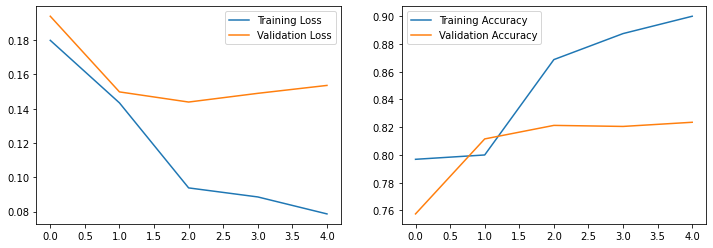

<Figure size 432x288 with 0 Axes>

In [220]:
epochs = len(losses)

plt.figure(figsize=(12, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
  plt.subplot(1, 2, i + 1)
  plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
  plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
  plt.legend()
plt.show()
plt.savefig('bert_accuracy.png')

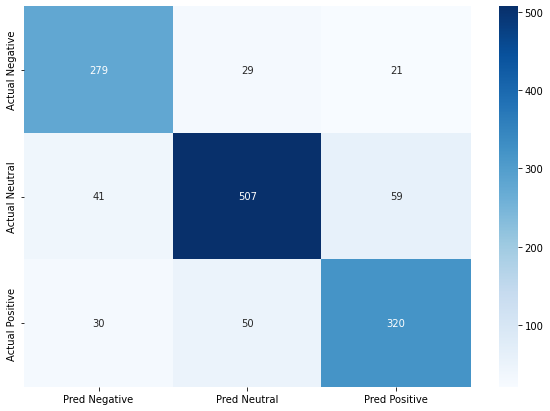

In [223]:
result = confusion_matrix(test_labels, final_prediction)
cf_matrix = pd.DataFrame(result, 
                         columns = ["Pred Negative", "Pred Neutral", "Pred Positive"],
                         index = ["Actual Negative", "Actual Neutral", "Actual Positive"])
plt.figure(figsize = (10,7))
sn.heatmap(cf_matrix, annot = True, cmap = 'Blues', fmt = '.3g')
plt.show()

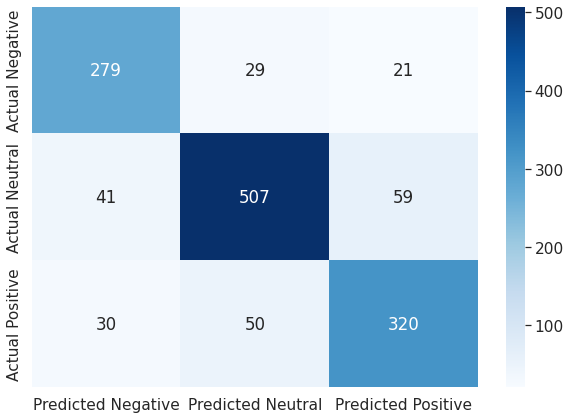

In [16]:
tl, tm, tr = 279, 29, 21
ml, mm, mr = 41, 507, 59
bl, bm, br = 30, 50, 320
t, m, b = tl+tm+tr, ml+mm+mr, bl+bm+br

test_labels_ls = [0]*t + [1]*m + [2]*b
predicted_labels_ls = [0]*tl + [1]*tm + [2]*tr + [0]*ml + [1]*mm + [2]*mr + [0]*bl + [1]*bm + [2]*br

result = confusion_matrix(test_labels_ls, predicted_labels_ls)
cf_matrix = pd.DataFrame(result, 
                                columns = ["Predicted Negative", "Predicted Neutral", "Predicted Positive"], 
                                index = ["Actual Negative", "Actual Neutral", "Actual Positive"])
plt.figure(figsize = (10,7))
sn.heatmap(cf_matrix, 
           annot=True, 
           cmap='Blues', 
           fmt='.3g')
plt.show()